In [89]:
documents = []

ego_id = '203226736'

file = open('Textos para testes/egos/' + ego_id + '.txt', 'r', encoding='utf-8')
for line in file:
    documents.append(line)
file.close()
'''
file = open('Textos para testes/alters/' + ego_id + '.txt', 'r', encoding='utf-8')
for line in file:
    documents.append(line)
file.close()
print(len(documents))
'''

"\nfile = open('Textos para testes/alters/' + ego_id + '.txt', 'r', encoding='utf-8')\nfor line in file:\n    documents.append(line)\nfile.close()\nprint(len(documents))\n"

In [90]:
documents1 = []
j = 0
for t in documents:
    if not t in documents1:
        documents1.append(t)
    else:
        j+=1
        #print(t)
print('Numero de textos repetidos: ' + str(j))

Numero de textos repetidos: 10


In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 1000 # max number of uniq words

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [92]:
from sklearn.decomposition import LatentDirichletAllocation

no_topics = 10
learning_decay = .7
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0,learning_decay = learning_decay).fit(tf)

In [93]:
import numpy as np
import pandas as pd

# Show top n keywords for each topic
def show_topics(vectorizer=tf_vectorizer, lda_model=lda, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=tf_vectorizer, lda_model=lda, n_words=12)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11
Topic 0,954590804,national,lake,world,park,photo,obama,photograph,france,president,dream,provide
Topic 1,1339835893,woman,new,anti,president,black,poll,meet,today,tribute,lose,watch
Topic 2,election,experience,story,2361224263,wait,supporters,line,adorable,imagine,angle,young,lose
Topic 3,568825492,like,954590804,70009161,report,talk,ur,want,dog,look,news,good
Topic 4,568825492,1582853809,photograph,old,know,954590804,year,day,sign,free,use,bad
Topic 5,make,saw,fun,25073877,great,america,final,just,look,bank,thank,tonight
Topic 6,1339835893,hillary,vote,watch,debate,friend,ballot,florida,25073877,make,000,supporters
Topic 7,25073877,trump,hillary,954590804,thank,1339835893,rally,president,state,photo,people,time
Topic 8,trump,say,work,try,right,03,1339835893,like,just,secretary,united,visit
Topic 9,americans,work,11,clinton,2916305152,1339835893,hillary,fbi,new,trump,63717541,plan


In [94]:
# column names
topicnames = ["Topic" + str(i) for i in range(no_topics)]

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(np.round(lda.components_, 2))

# Assign Column and Index
df_topic_keywords.columns = tf_vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# Vie
#list_frames = []
for t, row in df_topic_keywords.iterrows():
    aux = row.nlargest(12)
    #list_frames.append(aux.to_frame().T)
    print(t)
    a = ''
    for word, weight in aux.items():
        a += ' ' + word + ' (' + str(weight) + ') |'
    print(a)
    print('\n')

#list_frames[1]    

Topic0
 954590804 (23.26) | national (3.82) | lake (3.67) | world (3.33) | park (3.22) | photo (3.13) | obama (2.8) | photograph (2.12) | france (2.1) | president (1.72) | dream (1.71) | provide (1.66) |


Topic1
 1339835893 (4.92) | new (2.86) | woman (2.86) | anti (2.49) | president (2.41) | black (2.2) | poll (1.94) | meet (1.73) | today (1.73) | tribute (1.71) | lose (1.67) | watch (1.65) |


Topic2
 election (2.35) | experience (1.71) | 2361224263 (1.7) | story (1.7) | wait (1.65) | supporters (1.64) | line (1.6) | adorable (1.56) | imagine (1.21) | angle (1.19) | young (1.17) | lose (1.15) |


Topic3
 568825492 (8.04) | like (7.53) | 954590804 (6.03) | 70009161 (5.3) | report (3.55) | talk (3.43) | ur (3.43) | want (3.42) | dog (3.16) | look (2.83) | news (2.8) | good (2.73) |


Topic4
 568825492 (11.68) | 1582853809 (5.57) | photograph (5.43) | old (3.91) | know (3.56) | 954590804 (3.13) | year (3.1) | day (2.88) | sign (2.85) | free (2.78) | use (2.4) | bad (2.38) |


Topic5
 m

In [95]:
# Create Document - Topic Matrix
lda_output = lda.transform(tf)

# index names
docnames = [str(i) for i in range(len(documents))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 6), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
   color = 'green' if val > .1 else 'black'
   return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
style = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
style

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
0,0.011112,0.011111,0.011111,0.011111,0.011111,0.011112,0.011111,0.011111,0.011112,0.899997,9
1,0.774988,0.025001,0.025001,0.025003,0.025001,0.025001,0.025001,0.025001,0.025001,0.025001,0
2,0.025018,0.025001,0.025002,0.025007,0.025004,0.025001,0.025001,0.774964,0.025002,0.025002,7
3,0.014286,0.014286,0.014286,0.014287,0.014287,0.014287,0.014287,0.014288,0.014286,0.87142,9
4,0.050004,0.050001,0.050001,0.050005,0.050001,0.050001,0.050001,0.050001,0.050001,0.549986,9
5,0.010003,0.010001,0.01,0.909993,0.010001,0.01,0.01,0.010001,0.01,0.010001,3
6,0.699985,0.033335,0.033334,0.033336,0.033335,0.033334,0.033334,0.033335,0.033339,0.033334,0
7,0.025001,0.025001,0.025001,0.025015,0.025001,0.025001,0.025001,0.774975,0.025002,0.025002,7
8,0.050002,0.050002,0.050002,0.549973,0.050001,0.050001,0.050002,0.050008,0.050002,0.050008,3
9,0.774963,0.025002,0.025003,0.025017,0.025001,0.025002,0.025001,0.025007,0.025002,0.025002,0


In [96]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,71
1,7,57
2,4,55
3,3,53
4,9,36
5,6,25
6,5,25
7,8,21
8,1,21
9,2,11


In [100]:
#Documents of topic that classified most documents (First on the table above)

dominant_topic = df_document_topic['dominant_topic']

topic = df_topic_distribution['Topic Num'][0]

test_text = []
j = 0
for i, doc in enumerate(dominant_topic):
    if doc == topic:
        j+=1
        print('- ' + documents[i] + '  ')
        test_text.append(documents[i])

- 954590804 WINTER PUPPY THAT FACE 
  
- 954590804 POWER OF NATURE 
  
- 954590804 SANCTUARY MADONNA DELLA CORONA VERONA ITALY 
  
- 954590804 SUNSET SUNFLOWER FIELD MARYLAND 
  
- 954590804 TOSUA POOL SAMOA 
  
- 954590804 SPA POOL KARIJINI NATIONAL PARK WESTERN AUSTRALIA PHOTO PAUL PICHUGIN 
  
- 954590804 MAMA BEAR SNUGGLE CUB 
  
- 787644325 
  
- 954590804 TAHITIAN PRIVATE ISLAND FRENCH POLYNESIA 
  
- 954590804 THE TWELVE APOSTLES AUSTRALIA 
  
- 954590804 UNLIKELY BEST FRIENDS 
  
- 954590804 ANNECY FRANCE 
  
- 954590804 ABANDONED SHIP SAND BAR BERMUDA TRIANGLE 
  
- 954590804 A KITTY GUINEA 
  
- 954590804 REFLECTION LONDON ENGLAND 
  
- 954590804 OUR MOM BEST NIKOLAI ZINOVIEV 
  
- 954590804 AWESOME VIEW VERNAZZA CINQUE TERRE 
  
- 954590804 MARASMIUS HAEMATOCEPHALUS 
  
- 954590804 RIDING WAVE 
  
- 954590804 THIS CAT STRANGE UNIQUE FUR PATTERN 
  
- 954590804 STANDUP PADDLEBOARDING LAKE TAHOE 
  
- 954590804 DRONE CAPTURES LAKE BERRYESSA GLORY HOLE SPILLWAY OVERFLOWING FIRS

In [98]:
#Vectorize transform
text = tf_vectorizer.transform(test_text)

#LDA Transform
topic_probability_scores = lda.transform(text)

for i, doc in enumerate(topic_probability_scores):
    if not np.argmax(doc) == 1:
        print ('Document ' + str(i) + ':')
        print(np.argmax(doc))
        print(test_text[i])
        print(doc)

In [99]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += "   ".join([feature_names[i].replace('aa','@')
                            for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(message)
    print()

no_top_words = 12
display_topics(lda, tf_feature_names, no_top_words)

Topic #0: 954590804   national   lake   world   park   photo   obama   photograph   france   president   dream   provide
Topic #1: 1339835893   woman   new   anti   president   black   poll   meet   today   tribute   lose   watch
Topic #2: election   experience   story   2361224263   wait   supporters   line   adorable   imagine   angle   young   lose
Topic #3: 568825492   like   954590804   70009161   report   talk   ur   want   dog   look   news   good
Topic #4: 568825492   1582853809   photograph   old   know   954590804   year   day   sign   free   use   bad
Topic #5: make   saw   fun   25073877   great   america   final   just   look   bank   thank   tonight
Topic #6: 1339835893   hillary   vote   watch   debate   friend   ballot   florida   25073877   make   000   supporters
Topic #7: 25073877   trump   hillary   954590804   thank   1339835893   rally   president   state   photo   people   time
Topic #8: trump   say   work   try   right   03   1339835893   like   just   secretary

In [110]:
file = open('Textos para testes/egos/' + ego_id + '.txt', 'r', encoding='utf-8')
fonte = file.readlines()

autor = '1582853809'
for i in fonte:
    if autor in i:
        print(i)



1582853809 AT SEGREGATE DRINK FOUNTAIN MOBILE ALABAMA 1956 PHOTOGRAPH GORDON PARKS 

1582853809 MARILYN MONROE SIGN AUTOGRAPH FAN SET SOME LIKE IT HOT 1959 PHOTOGRAPH RICHARD MILLER 

1582853809 MUHAMMAD ALI TRAIN 1974 PHOTOGRAPH KEN REGAN 

1582853809 THE FIRST KNOW PHOTOGRAPH PRESIDENTIAL INAUGURATION PRESIDENT JAMES BUCHANAN MARCH 1857 

1582853809 A MUSLIM WOMAN COVER YELLOW STAR JEWISH NEIGHBOR VEIL PROTECT SARAJEVO 1941 

1582853809 A DAREDEVIL BALANCE BACK LEGS CHAIR ATOP FURNITURE 20 STORIES NEW YORK CIRCA 1920 PHOTO 

1582853809 CZESLAWA KWOKA AGE 14 AUSCHWITZ PRISONER IDENTITY PHOTO DECEMBER 1942 PHOTOGRAPH WILHELM BRASSE 

1582853809 SENATOR HIRAM RHODES REVELS FIRST AFRICAN AMERICAN SIT US SENATE CIRCA 1870 PHOTOGRAPH MATHEW BRADY 

1582853809 PHOTO BOOTH SELF PORTRAIT NORMA JEANE BAKER SOON HOLLYWOOD ICON MARILYN MONROE CIRCA 1940 

1582853809 FORMER UNITED STATES SECRETARY STATE COLIN POWELL SELFIES 60 YEARS FACEBOOK FOLKS 

1582853809 EIGHTEEN YEAR OLD INVENTOR H DAY WEA

In [76]:
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')
panel

c:\users\pc-dell\appdata\local\programs\python\python36\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1       61.134010   15.631278       1        1  18.909478
5       -3.925001  -64.845634       2        1  15.061943
9     -133.559128   81.990265       3        1  12.478021
6       86.157600 -126.828285       4        1  11.788293
4     -125.288979  -51.381866       5        1  10.958237
8      116.698860  106.818443       6        1   8.161180
0      -51.140869 -158.988998       7        1   7.550981
7      -41.277584   31.747908       8        1   5.487968
3       -4.157195  136.183578       9        1   5.368359
2      159.202423  -27.924910      10        1   4.235540, topic_info=     Category       Freq               Term      Total  loglift  logprob
term                                                                    
28    Default  24.000000      aaplanetepics  24.000000  30.0000  30.0000
32    Default  11.000000  aarealdonaldtrump  11.000000  29.0000  29.0000
20    Default  18.000000   aahillaryclinton  18.000000  28.0000  28.0000
13    Default  12.000000    aacuteemergency  12.000000  27.0000  27.0000
336   Default   7.000000              thank   7.000000  26.0000  26.0000
346   Default  13.000000              trump  13.000000  25.0000  25.0000
167   Default  11.000000            hillary  11.000000  24.0000  24.0000
254   Default   6.000000         photograph   6.000000  23.0000  23.0000
206   Default   5.000000               look   5.000000  22.0000  22.0000
21    Default   5.000000    aahistoryinpics   5.000000  21.0000  21.0000
60    Default   3.000000                bad   3.000000  20.0000  20.0000
14    Default   5.000000    aacuteoverloads   5.000000  19.0000  19.0000
202   Default   8.000000               like   8.000000  18.0000  18.0000
156   Default   5.000000              great   5.000000  17.0000  17.0000
284   Default   4.000000             report   4.000000  16.0000  16.0000
100   Default   3.000000           congress   3.000000  15.0000  15.0000
11    Default   3.000000       aacjtfarrell   3.000000  14.0000  14.0000
376   Default   3.000000             wonder   3.000000  13.0000  13.0000
338   Default   5.000000              today   5.000000  12.0000  12.0000
93    Default   2.000000              close   2.000000  11.0000  11.0000
252   Default   5.000000             people   5.000000  10.0000  10.0000
380   Default   4.000000              world   4.000000   9.0000   9.0000
137   Default   4.000000                fbi   4.000000   8.0000   8.0000
107   Default   3.000000                day   3.000000   7.0000   7.0000
263   Default   4.000000               poll   4.000000   6.0000   6.0000
48    Default   5.000000          americans   5.000000   5.0000   5.0000
154   Default   4.000000               good   4.000000   4.0000   4.0000
365   Default   6.000000               want   6.000000   3.0000   3.0000
251   Default   3.000000       pennsylvania   3.000000   2.0000   2.0000
296   Default   2.000000            sanders   2.000000   1.0000   1.0000
...       ...        ...                ...        ...      ...      ...
33    Topic10   0.440911      aarobertbluey   2.723510   1.3408  -4.9338
295   Topic10   0.451469          sanctuary   2.849633   1.3192  -4.9101
89    Topic10   0.451429             cities   3.084846   1.2398  -4.9102
125   Topic10   0.407991                end   2.908285   1.1976  -5.0114
22    Topic10   0.406770       aajaketapper   2.959045   1.1773  -5.0144
143   Topic10   0.381806            foreign   2.883239   1.1399  -5.0777
55    Topic10   0.384878            attacks   2.924568   1.1337  -5.0697
363   Topic10   0.383774                 vs   2.942057   1.1248  -5.0726
62    Topic10   0.382282               bank   2.949550   1.1184  -5.0765
6     Topic10   0.369888                 14   2.900175   1.1023  -5.1095
174   Topic10   0.364043                hrc   3.313233   0.9533  -5.1254
101   Topic10   0.288084         corruption   2.7

Text(0.5,1,'Segregation of Topic Clusters')

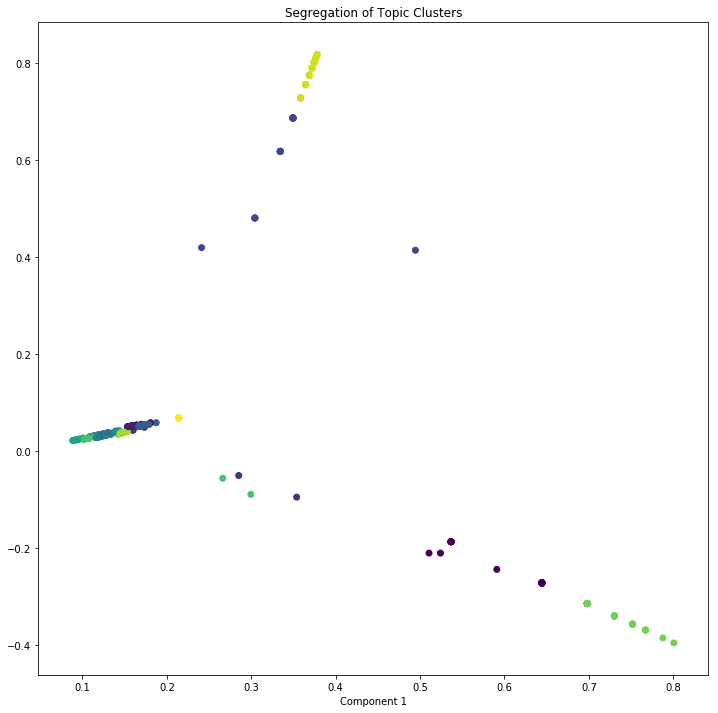

In [77]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
from sklearn.decomposition import TruncatedSVD
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [14]:
#Separando novos documentos baseado nos pesos do LDA

new_documents = []
threshold = .8
for index, row in df_document_topic.iterrows():
    best_topic = row['dominant_topic']
    column = 'Topic'+str(int(best_topic))
    if row[column] >= threshold:
        new_documents.append(documents[int(index)])
        
print(len(new_documents))
documents = new_documents

139
